# BUT : On a plusieurs joueurs et ils doivent donner la couleur de l'ensemble des chevelures teintes soit en orange soit en indigo
Pour cela, la premiere personne à être intérogée (q0), devra dire indigo, si le nombre de chevelure indigo qu'elle voit devant elle est impaire (et la valeur du qbits sera de 1)

Sinon, elle devra dire orange et le qubits sera 0

Ensuite, le q1 saura la réponse de q0 et pourra determiner sa couleur en fonction de ce qu'il voit lui même

De manière générale, qn pour savoir grace aux infos de qn-1 sa couleur de cheveux, hormis q0 qui à 50% de chances de se tromper sur sa propre couleur, mais cela n'empechera pas de résoudre l'enigme

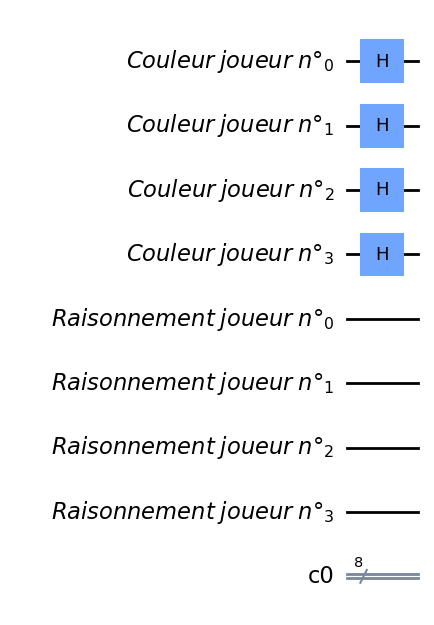

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import matplotlib
from qiskit import Aer
from qiskit.visualization import plot_state_city

# Le nombre de joueurs qu'on a, dans notre exemple 4
players = 4

# Création du circuit quantique permettant de determiner la couleur de l'ensemble des chevelures avec la plus grand probabilité
# Tout d'abord, on ajoute un qbits par joueur, puis 1 par raisonnement, qui seront la determination de leur chevelure selon ce qu'il ont entendu des joueurs d'avant (intrication)

playerRegister = QuantumRegister(players, "Couleur joueur n°")
answerRegister = QuantumRegister(players, "Raisonnement joueur n°")
classicalRegister = ClassicalRegister(players*2)
circ = QuantumCircuit(playerRegister,answerRegister,classicalRegister)

# Ajout d'une porte hadamard sur tous les qbits de couleur de teinture des joueurs, pour simuler le hasard de la couleur de leur propre chevelure
for i in range(players):
    circ.h(i)

# controle du bon nombre de qbits, chaque joueur à sa couleur aléatoire (H) et sa pensée, donc players*2 au total
circ.draw(output='mpl')

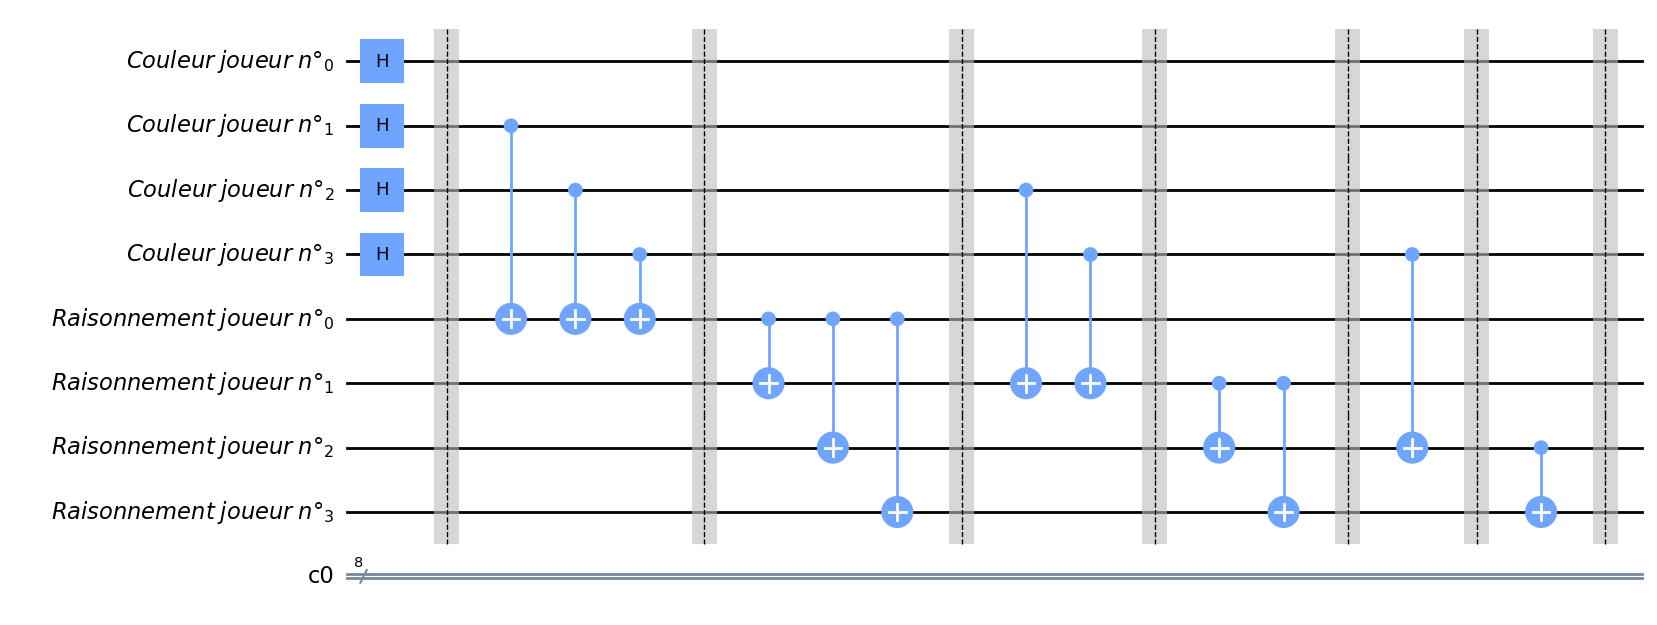

In [2]:
# séparation visuelle
circ.barrier()

# on doit donner les réponses selon la parité de celui qui a répondu avant
# - 1 car le premier joueur (q0) n'a personne avant lui pour qu'il puisse prendre en compte des réponses, on s'en occupe donc pas
playerLeft = players - 1
# currentPlayerMindsetIndex permet de savoir où on en est dans le raisonnement, qui est actuellement en train de determiner sont raisonnement selon les réponses précédentes et ce qu'il voit, on commence par q0
currentPlayerMindsetIndex = 0

# On va créer le circuit pour tous les joueurs, du premier au dernier, pour chacun fasse son resonnement selon les précédents et que les suivant "notent" la réponse (CNOT pour les intriquer et savoir si indigo pair ou impaire)
while playerLeft > 0:
    
    # permet de partir des joueurs qui sont devant le joueur sur lequel on est actuellement
    playerInFrontOfCurrent = players-playerLeft
    
    # You check if the number of indigo hair color in front of you is even or odd
    # Verifier si le nombre de cheveux indigo devant est pair ou impaire à l'aide de porte CNOT
    # Quand la couleur est indigo, q = 1, donc selon le nombre de fois que la porte se déclanche, cela donnera l'info de la parité
    # effectivement, si c'est impaire, le déclanchement des CNOT donnera toujours 1, ce qui dit bien qu'il y a un nombre de chevelure indigo impaire
    # sinon ce sera 0, par exemple si 2 chevelure indigo son devant et 1 orange, la CNOT inversera 2 fois le qbits, donc il sera 0, si c'est 3 fois, il sera de 1
    for i in range(playerLeft):
        circ.cx(i+playerInFrontOfCurrent, players+currentPlayerMindsetIndex)

    circ.barrier()

    # Tous les prochains joueurs doivent prendre en compte la raisonement du joueur actuel
    # Donc pour tous les raisonnements restants (i+players+currentPlayerMindsetIndex+1)
    #     on créé un CNOT qui part des reponses du joueur actuel (players+currentPlayerMindsetIndex)
    for i in range(playerLeft):
        circ.cx(players+currentPlayerMindsetIndex, i+players+currentPlayerMindsetIndex+1)

    circ.barrier()
    
    # on passe au joueur suivant, donc ca nous fait un joueur en moinds à traiter, on reduit notre boucle
    playerLeft = playerLeft - 1
    # mais on ajoute un pour prendre ensuite le prochain raisonement, du prochain joueur
    currentPlayerMindsetIndex = currentPlayerMindsetIndex + 1

# controle du circuit pour verifier le modèle, on voit bien que joueur n donne sa réponse selon les infos de joueur n-1
circ.draw(output='mpl')

# Affichage des probalité
on voit qu'il y a pour players = 4, 16 possibilités de répartition des teintures sur cette shpere de bloch ou toutes les valeurs sont affichés (on va voir comment les lire ensuite)

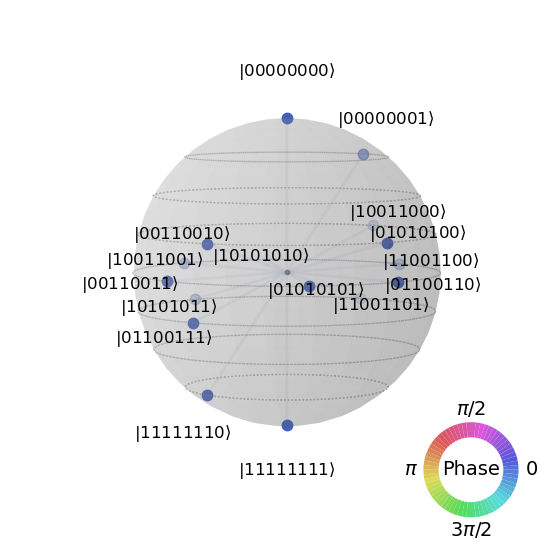

In [3]:
from qiskit.visualization import plot_state_qsphere

# recuperation du resultat pour affichage des probabilités ou de calculs
def getResult(circ):
    backend = Aer.get_backend('statevector_simulator') # simulateur quantique
    job = backend.run(circ) # execution du circuit quantique et recuperation des resultats (probabilité vector ou valeurs selon si un measure est passé au circuit)
    return job.result()

outputstate = getResult(circ).get_statevector(circ, decimals=3)
plot_state_qsphere(outputstate) # affichage de la sphere de bloch qui nous montre toutes les possibilités visuellement

# Intéprétation et calcul d'un resultat

In [4]:
# comme on a 2 QuantumRegister de n players elements (q0 à q3 pour les couleurs des cheveux et q4 à q7 pour les raisonnements dans le cas players = 4)
# il faut faire 2 measures de n chacun
hairMeasures = [element for element in range(players)]
mindMeasures = [element for element in range(players, players*2)]
circ.measure(hairMeasures,hairMeasures)
circ.measure(mindMeasures,mindMeasures)
counts = getResult(circ).get_counts(circ) # Récupère un resultat au hasard, on prend la valeur de nos qubits (à lire de droite à gauche)
readableResult = list(counts)[0];

print(f"Resultat : {readableResult}")

def parseValueToColor(value):
    return 'orange' if value == '0' else 'indigo'

# Si on divise le resultat en deux, les deux moitiés sont identiques
leftPart = readableResult[:len(readableResult) // 2]
rightPart = readableResult[len(readableResult) // 2:]
print(f"Partie gauche : {leftPart}")
print(f"Partie droite : {rightPart}")

# ... Sauf le dernier de chaque moitié !
# en réalité tous les autres donnent la couleur de teinture du joueur respectif
# Mais pour le dour le dernier, il s'agit pour la partie gauche de l'indication de parité sur les chevelure que q0 à donné, c'est à dire q4 dans un exemple où players=4 (car de droite à gauche)
# Celui de la partie de droit correspond à la couleur de cheveux de q0 mais seulement juste à 50% du temps (puisque personne ne lui à donné de parité avant)
# on obtient donc cette suite de couleurs, donc tous les élèments hormis le premier sont juste

print(f"Parité : {leftPart[-1]}") # dernier ellement, puisque c'est de droite à gauche
print("\nSuite de teinture :")
for element in reversed(rightPart):
    print(parseValueToColor(element))


Resultat : 10011000
Partie gauche : 1001
Partie droite : 1000
Parité : 1

Suite de teinture :
orange
orange
orange
indigo


On a donc résolu, sans donner plus d'un mot par joueur, la suite de teinture pour un nombre N de joueurs.

Le resultat affiche un exemple de qbits qui nous montre aisément, comme l'explique les commentaires, la parité utilisé, la couleur possible du premier jour avec une chance de 50% d'avoir juste, et avec certitude la suite de couleurs de tous les autres joueurs, en fonction de ce que les joueurs avant lui ont pu donner comme information (orange ou indigo pour pair ou impaire), leur permettant de determiner leur propre couleur de teinture et de déroulé toute la suite ainsi